Trying EfficientNet b7 on Food101. B4 Efficient nets are 2 times te width of the b0 networks, 3.1 times the depth, we used 600 image resolution as compared to 224 in b0, and dropout of 0.5 compared to 0.2 in b0.

In [0]:
# cheking the number of cored this system has.
!cat /proc/cpuinfo | grep "cpu cores" | uniq

cpu cores	: 2


Getting the idea of the GPU we are assigned. I am running it on Colab pro, hence got p-100 chips compared to k-80. If you are running it on k80, try to run by reducing the batch size. 

In [0]:
!nvidia-smi

Wed Jun  3 08:24:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

During the time of writing this code, there was an compatibility issue of latest released pytorch with fastai. So we downgraded our torch and torchvision to previous release. Also, we can go download the latest dev branch for fastai, using the commented out code. But it seems to create issues sometimes. 

In [0]:
# !pip install git+https://github.com/fastai/fastai.git
!pip install torch===1.4.0 torchvision===0.5.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 753.4MB 23kB/s 
     |████████████████████████████████| 4.0MB 31.6MB/s 
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101


In [0]:
# creating a directory to store all the results
!mkdir /content/models

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

### Data Preparation

Food101 dataset is available with FastAI. So, downloading and untaring it directly.

In [0]:
path = untar_data(URLs.FOOD)

In [0]:
path.ls()

[PosixPath('/root/.fastai/data/food-101/classes.txt'),
 PosixPath('/root/.fastai/data/food-101/train.json'),
 PosixPath('/root/.fastai/data/food-101/labels.txt'),
 PosixPath('/root/.fastai/data/food-101/train.txt'),
 PosixPath('/root/.fastai/data/food-101/test.txt'),
 PosixPath('/root/.fastai/data/food-101/test.json'),
 PosixPath('/root/.fastai/data/food-101/images'),
 PosixPath('/root/.fastai/data/food-101/h5')]

As we know and can see that we have separate train and test images based on data available in train.txt and test.txt. Also, since the dataset specifies an equal amount of examples for each category, we do not need to worry about class imbalances. 

The training set is split into 20% for the validation set and 80% for the training set.

The examples for each category are located in subdirectories with the category names. The file list is treated like a csv file, though now delimited with a '/' symbol. This is read using Pandas into a Pandas DataFrame structure and then is modified so that the paths and .jpg file extensions are added. Fast AI provides a way of reading the DataFrame structure and indicating that the labels are in column 0 and the examples are in column 1

In [0]:
train_path = '/root/.fastai/data/food-101/train.txt'
test_path = '/root/.fastai/data/food-101/test.txt'

def filelist2df(path):
    df = pd.read_csv(path, delimiter='/', header=None, names=['label', 'name'])
    df['name'] =  df['label'].astype(str) + "/" + df['name'].astype(str) + ".jpg"
    return df

train_df = filelist2df(train_path)
test_df = filelist2df(test_path)

Setting the seed for all the randomizations, so that we get the same result on running the code again.

In [0]:
# batch size
bs = 6
# image resolution
img_size = 600

We are going to use the cleaned data csv file we created in efficientnet b4 for generating the data. We can copy it to our local directory or if you don't have it than follow the procedure in efficientnet b4 notebook to clean the data.

In [0]:
!cp /content/drive/'My Drive'/DeepLearning/EfficientNet/b4-512/cleaned.csv /content/models/cleaned.csv 

In [0]:
# defining the data augmentation 
ds_tfms = ([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-40, 40)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmAffine (flip_affine), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.4), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.35, 0.65)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.7, 1.43)}, p=0.75, resolved={}, do_run=True, is_random=True),
            RandTransform(tfm=TfmCoord (jitter), kwargs={'magnitude': (-0.01, 0.01)}, p=0.3, resolved={}, do_run=True, is_random=True),
            RandTransform(tfm=TfmCoord (skew), kwargs={'direction': (0, 7), 'magnitude': (0.2)}, p=0.75, resolved={}, do_run=True, is_random=True),
            RandTransform(tfm=TfmAffine (squish), kwargs={'scale': (0.42, 2.4), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True)], 
           [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True)])

data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='/content/models/cleaned.csv', ds_tfms=ds_tfms, bs=bs, size=img_size, num_workers=2).normalize(imagenet_stats)

Installing the Efficientnet for pytorch. This is not default in Fastai and is independently developed in a git repo.

In [0]:
pip install --upgrade efficientnet-pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12422 sha256=4ff90926ebf68c493d9791ca42117f720e7a64868e3ed575c057cf1a89f6156f
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
Successfully built efficientnet-pytorch


In [0]:
from efficientnet_pytorch import EfficientNet

In [0]:
model = EfficientNet.from_pretrained("efficientnet-b7")
arch = model

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/checkpoints/efficientnet-b7-dcc49843.pth



Loaded pretrained weights for efficientnet-b7


In [0]:
top_5 = partial(top_k_accuracy, k=5)

learn = Learner(data, model, metrics=[accuracy, top_5], callback_fns=ShowGraph).to_fp16()
learn.split( lambda m: (model._conv_head,) )

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.02E-03
Min loss divided by 10: 1.32E-03


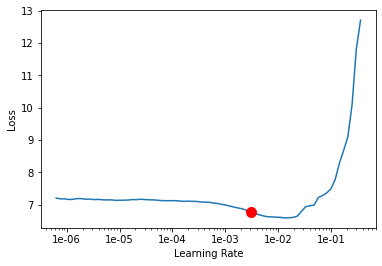

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.529082,2.101316,0.563026,0.805591,3:28:25
1,1.588730,1.155774,0.749155,0.920382,3:28:28
2,1.305934,0.826850,0.816652,0.951646,3:28:32


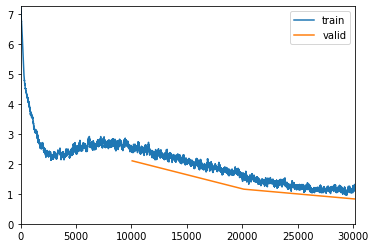

In [0]:
lr = 4e-3
learn.fit_one_cycle(3, max_lr=slice(lr))
learn.save('/content/models/food-101-train-epoch-3')

In [0]:
learn = Learner(data, model, metrics=[accuracy, top_5], callback_fns=ShowGraph).to_fp16()
learn.split( lambda m: (model._conv_head,) )
learn.load('/content/models/food-101-train-epoch-3');

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 8.32E-05


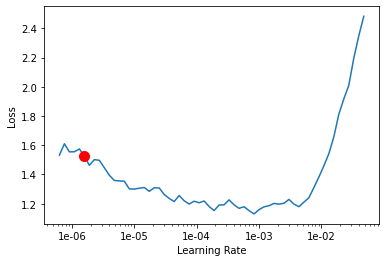

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.142860,0.757622,0.834139,0.959462,3:28:20


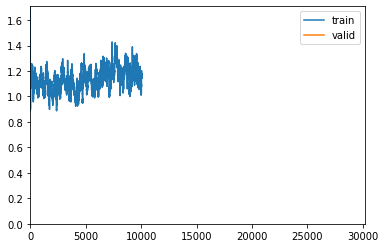

Buffered data was truncated after reaching the output size limit.

In [0]:
lr = 1e-3
learn.fit_one_cycle(3, max_lr=slice(1e-4, lr))
learn.save('/content/models/food-101-train-epoch-6')

In [0]:
top_5 = partial(top_k_accuracy, k=5)

learn = Learner(data, model, metrics=[accuracy, top_5], callback_fns=ShowGraph).to_fp16()
learn.split( lambda m: (model._conv_head,) )
learn.load('/content/models/food-101-train-epoch-6');

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.10E-07


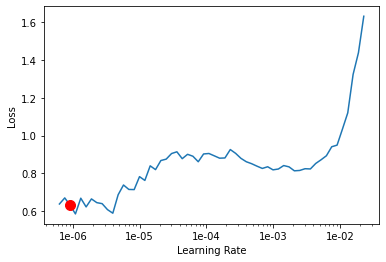

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.933083,0.498055,0.883752,0.976419,3:28:35
1,0.807974,0.489252,0.883950,0.976750,3:28:58
2,0.798576,0.477077,0.888123,0.977413,3:28:25


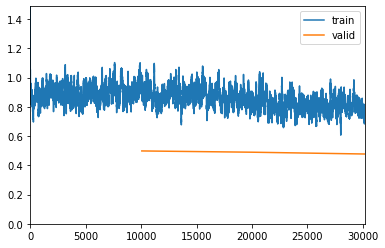

In [0]:
lr = 3e-4
learn.fit_one_cycle(3, max_lr=slice(3e-5, lr))
learn.save('/content/models/food-101-train-epoch-9')

In [0]:
!cp /content/drive/'My Drive'/DeepLearning/EfficientNet/b7/food-101-train-epoch-9.pth /content/models/food-101-train-epoch-9.pth

In [0]:
top_5 = partial(top_k_accuracy, k=5)

learn = Learner(data, model, metrics=[accuracy, top_5], callback_fns=ShowGraph).to_fp16()
learn.split( lambda m: (model._conv_head,) )
learn.load('/content/models/food-101-train-epoch-9')

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-06
Min loss divided by 10: 8.32E-07


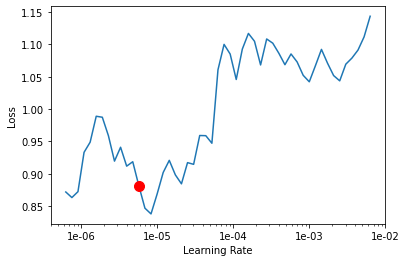

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.757140,0.422337,0.902431,0.978737,3:28:45


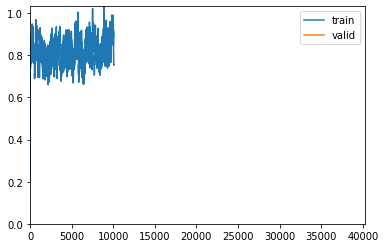

Buffered data was truncated after reaching the output size limit.

In [0]:
lr = 4e-4
learn.fit_one_cycle(4, max_lr=slice(7e-6, lr))
learn.save('/content/models/food-101-train-epoch-13')

In [0]:
!cp /content/drive/'My Drive'/DeepLearning/EfficientNet/b7/food-101-train-epoch-13.pth /content/models/food-101-train-epoch-13.pth

In [0]:
top_5 = partial(top_k_accuracy, k=5)

learn = Learner(data, model, metrics=[accuracy, top_5], callback_fns=ShowGraph).to_fp16()
learn.split( lambda m: (model._conv_head,) )
learn.load('/content/models/food-101-train-epoch-13')

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 4.37E-06


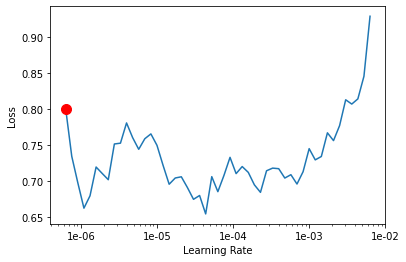

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.820386,0.388296,0.908922,0.982579,3:28:11
1,0.884535,0.400050,0.907200,0.982248,3:28:33
2,0.654026,0.390180,0.908326,0.982778,3:28:28


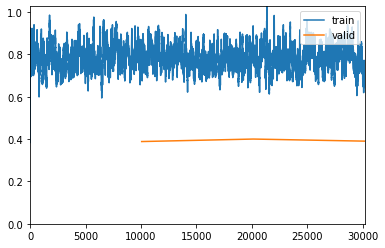

In [0]:
lr = 1e-4
learn.fit_one_cycle(3, max_lr=slice(1e-6, lr))
learn.save('/content/models/food-101-train-epoch-16')

In [0]:
!cp /content/drive/'My Drive'/DeepLearning/EfficientNet/b7/food-101-train-epoch-16.pth /content/models/food-101-train-epoch-16.pth

In [0]:
test_data = (ImageList.from_df(df=test_df, path=path/'images', cols=1)
            .split_none()
            .label_from_df(cols=0)
            .transform(size=600)
            .databunch(bs=bs)
            .normalize(imagenet_stats))

top_5 = partial(top_k_accuracy, k=5)
learn = Learner(test_data, model, metrics=[accuracy, top_5]).to_fp16()
learn.load('/content/models/food-101-train-epoch-16')

In [0]:
learn.validate(test_data.train_dl)

[0.43182766, tensor(0.8990), tensor(0.9825)]

In [0]:
test_data = (ImageList.from_df(df=test_df, path=path/'images', cols=1)
            .split_none()
            .label_from_df(cols=0)
            .transform(ds_tfms, size=600)
            .databunch(bs=bs)
            .normalize(imagenet_stats))

top_5 = partial(top_k_accuracy, k=5)
learn = Learner(test_data, model, metrics=[accuracy, top_5]).to_fp16()
learn.load('/content/models/food-101-train-epoch-16')

In [0]:
log_preds, y = learn.TTA(ds_type=test_data.train_dl)
# predIdxs = np.argmax(log_preds.numpy(), axis=1)
accuracy(log_preds, y)

tensor(0.9065)